# ЗАНЯТИЕ 12. TensorFlow Keras. Классификация изображений (на примере распознавания цифр 0–9)[1]

[1] <span>&#9757;&#128578;</span> Данное занятие разработано на основе русскоязычной книги – [21] в списке источников и литературы.

## Цели занятия

Написание программы для распознавания цифр на базе `TensorFlow Keras`. Создание нейросети и её обучение по базе данных `MNIST`. Тестирование `MNIST` выборкой и пользовательскими картинками.

## Порядок выполнения работы

### Общая часть

На данном занятии будет создана нейронная сеть, которая классифицирует изображения рукописных цифр. При написании программы будет использоваться надстройка «`tf.keras`», которая является высокоуровневой `API` (англ. application programming interface – программный интерфейс приложения) для построения и обучения моделей в `TensorFlow`.

Подключим все необходимые библиотеки (модули):

In [1]:
# Подключаем TensorFlow и tf.keras
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import plot_model

# Подключаем вспомогательные библиотеки numpy и matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.3.0


На данном занятии будет использоваться датасет `MNIST` который содержит 60,000 обучающих монохромных изображений в 10 категориях (+10,000 для тестирования). На каждом изображении содержится по одной цифре в низком разрешении (28 на 28 пикселей, см. рис. ниже).

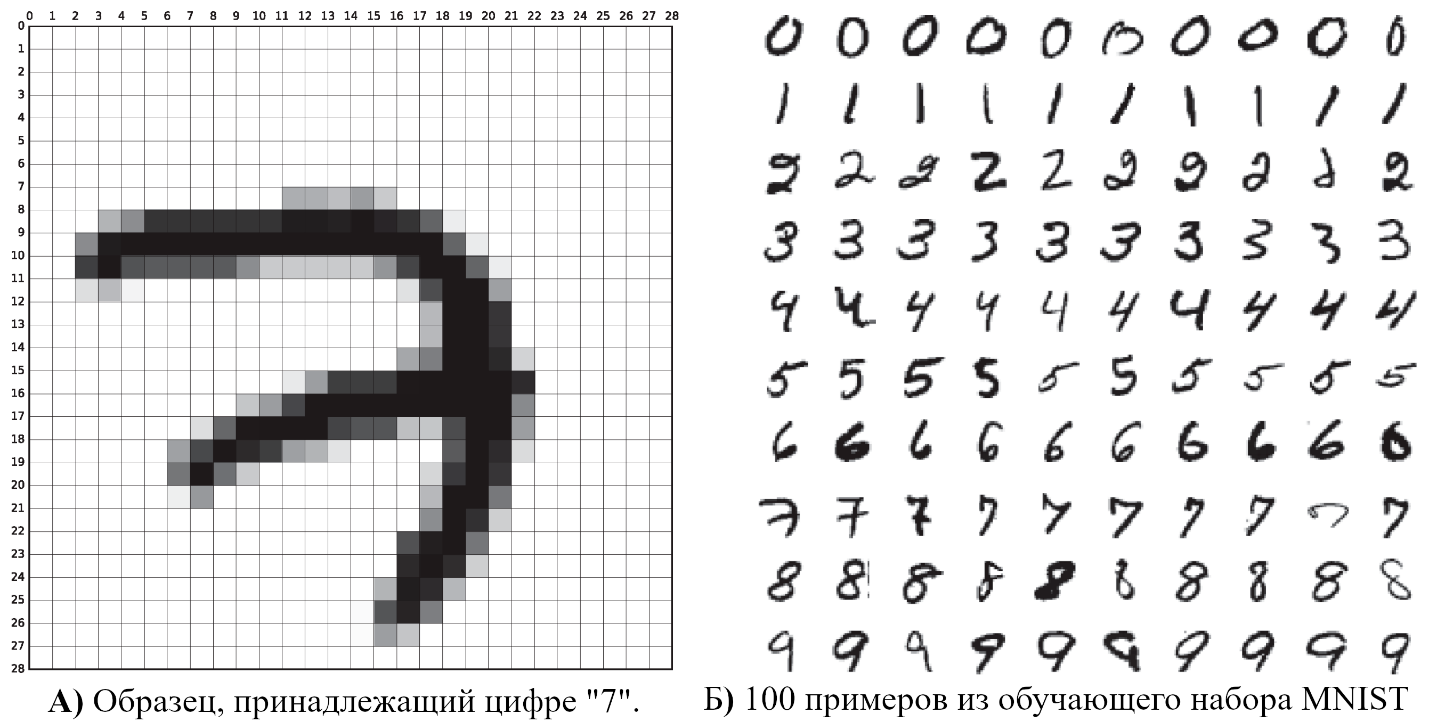

Рис. 1. Датасет MNIST

`MNIST` часто используют как «`Hello, World`» программ машинного обучения для компьютерного зрения. Он относительно мал и содержит изображения рукописных цифр (0, 1, 2, и т.д.), и используются для проверки корректности работы алгоритма нейросети.

Мы будем использовать 60,000 изображений для обучения нейросети и 10,000 изображений чтобы проверить, насколько правильно сеть обучилась их классифицировать. Получить доступ к `MNIST` можно прямо из `TensorFlow` – импортируем его:

In [2]:
from tensorflow.keras.datasets import mnist

fashion_mnist = mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# Из диапазона 0-255 преобразуем к диапазону 0-1, чтобы нейросеть
# работала не со значениями [0;255], а [0;1].
train_images = train_images / 255.0
test_images = test_images / 255.0

Загрузка датасета возвращает четыре массива `NumPy`:

-   массивы «`train_images`» и «`train_labels`» являются обучающей (или, как часто говорят за рубежом – тренировочной) выборкой – т.е. данными, на которых модель будет обучаться;

-   модель тестируется на проверочном сете (наборе данных), а именно массивах «`test_images`» и «`test_labels`».

Изображения являются 28х28 массивами `NumPy` (т.е. каждое из 60,000 изображений имеет размер 28*28 пикселей), где значение пикселей варьируется от 0 до 255 (под значением пикселей имеется ввиду цветность). Метки «`labels`» – это массив целых чисел от 0 до 9. Они соответствуют классам цифр, изображенных на картинках, что представлено в таблице ниже (Таблица 1):

Таблица 1. Метки классов

<table>
<colgroup>
<col style="width: 49%" />
<col style="width: 50%" />
</colgroup>
<thead>
<tr class="header">
<th>

<strong>Метки «</strong><span data-custom-style="code_in_text Char">labels</span><strong>»</strong>

</th>
<th>

<strong>Класс</strong>

</th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td>

0

</td>
<td>

0

</td>
</tr>
<tr class="even">
<td>

1

</td>
<td>

1

</td>
</tr>
<tr class="odd">
<td>

…

</td>
<td>

…

</td>
</tr>
<tr class="even">
<td>

9

</td>
<td>

9

</td>
</tr>
</tbody>
</table>

Каждому изображению соответствует единственная метка. Так как названия классов не включены в датасет, сохраним их в переменную `class_names` для дальнейшего использования при классификации изображений:

In [3]:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]  

Чтобы убедиться, что перед обучением модели данные в правильном формате и мы готовы построить и обучить нейросеть, выведем на экран первые 25 изображений из обучающей выборки и отобразим под ними наименования их классов. Для более простого понимания кода после вывода 25–ти изображений так же выведем всего лишь одно, имеющее индекс 0:

первые 25 изображений из датасета:


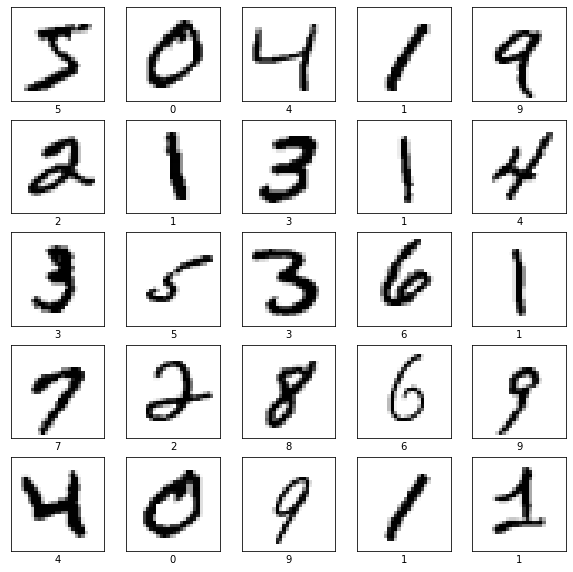

изображение с индексом 0:


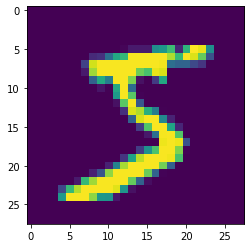

In [4]:
# Просмотреть первые 25 изображений из датасета
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
print("первые 25 изображений из датасета:")
plt.show()

# Просмотреть изображение с индексом 0
plt.imshow(train_images[0])
print("изображение с индексом 0:")
plt.show()

Рис. 2. Первые 25 изображений из датасета `train_images`

Рис. 3. Изображение `train_images[0]`

</td>
</tr>
</tbody>
</table>

Теперь построим модель нейронной сети – т.е. зададим структуру нашей нейросети:

In [5]:
model = keras.Sequential([
keras.layers.Flatten(input_shape=(28, 28)),
keras.layers.Dense(128, activation="relu"),
keras.layers.Dense(10, activation="softmax"),])

Первый слой этой сети – `tf.keras.layers.Flatten`, преобразует формат изображения из двумерного массива (28 на 28 пикселей) в одномерный (размерностью 28 * 28 = 784 пикселя). Данный слой извлекает строки пикселей из изображения и выстраивает их в один ряд. Этот слой не имеет параметров для обучения; он только переформатирует данные.

После разложения пикселей, нейросеть содержит два слоя `tf.keras.layers.Dense`. Это полносвязные нейронные слои.

Первый слой состоит из 128 нейронов с функцией активации `relu`. Данный слой осуществляет основную «логику» по классификации чисел. Нейроны так же называются узлами.

Второй слой – 10–ти узловой с функцией активации `softmax`. Он возвращает массив из 10 вероятностных оценок, дающих в сумме 1. Каждый нейрон второго слоя на выход выводит оценку, указывающую вероятность принадлежности изображения к одному из 10 классов.

Прежде чем модель будет готова для обучения, нам нужно указать еще несколько параметров:

-   функция потерь (`loss function`) – измеряет точность модели во время обучения. Необходимо минимизировать эту функцию, чтобы «направить» модель в верном направлении;

-   оптимизатор (`optimizer`) – показывает каким образом обновляется модель на основе входных данных и функции потерь;

-   метрики (`metrics`) – используются для мониторинга обучения и тестирования модели. Наш пример использует метрику «`accuracy`», равную доле правильно классифицированных изображений.

Описанные выше параметры указываются на шаге компиляции модели:

In [6]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

Теперь обучим нашу нейросеть. Обучение модели нейронной сети требует выполнения следующих шагов:

1.  подать обучающую выборку в модель. В этом примере обучающие данные – это массивы `train_images` и `train_labels`;

2.  модель обучится ассоциировать изображения с правильными классами;

3.  сделать прогнозы для проверочных данных (массив `test_images`). Произойдет проверка, соответствуют ли предсказанные классы меткам из массива `test_labels`.

Запустим обучение при помощи вызова метода `model.fit()`. В процессе обучения модели отображаются метрики потери (`loss`) и точности (`accuracy`). Эта модель достигает на тренировочных данных точности равной приблизительно 0.88 (92-98%):

Epoch 1/3
1875/1875 [==============================] - 1s 743us/step - loss: 0.2560 - accuracy: 0.9278
Epoch 2/3
1875/1875 [==============================] - 1s 741us/step - loss: 0.1140 - accuracy: 0.9668
Epoch 3/3
1875/1875 [==============================] - 1s 705us/step - loss: 0.0789 - accuracy: 0.9762
dict_keys(['loss', 'accuracy'])


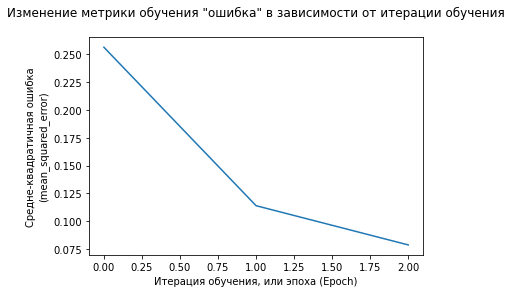

In [7]:
history = model.fit(train_images, train_labels, epochs=3)

print(history.history.keys())
plt.title('Изменение метрики обучения "ошибка" в зависимости от итерации обучения\n')
plt.xlabel("Итерация обучения, или эпоха (Epoch)")
plt.ylabel("Средне-квадратичная ошибка\n(mean_squared_error)")
plt.plot(history.history["loss"])

Рис. 4. Метрика «ошибка обучения» в задаче распознавания цифр

Далее сравним какую точность модель покажет на проверочном датасете относительно тренировочного датасета:

In [8]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print("Точность на проверочных данных:", test_acc)

313/313 - 0s - loss: 0.0933 - accuracy: 0.9708
Точность на проверочных данных: 0.97079998254776


Полученная на проверочном сете точность (97.3%) оказалась немного ниже, чем на тренировочном (97.6%, см. `accuracy` в выводе обучения). Этот разрыв между точностью на обучении и тестировании является примером переобучения (на англ. – `overfitting`). Переобучение возникает, когда модель машинного обучения показывает на новых данных худший результат, чем на тех, на которых она обучалась.

Теперь, когда модель обучена, мы можем использовать ее чтобы сделать предсказания по поводу нескольких изображений. Полученная модель предскажет класс цифры для каждого изображения в проверочном датасете. Давайте посмотрим на первое предсказание:

In [9]:
predictions = model.predict(test_images)  
print(predictions[0])  

[4.7806232e-05 7.5117896e-08 3.0997134e-04 3.1073496e-04 5.5217346e-09
 1.2366154e-07 1.2817760e-09 9.9925095e-01 8.0150330e-06 7.2359435e-05]


Прогноз представляет из себя массив из 10 чисел. Они описывают «уверенность» модели в том, насколько изображение соответствует каждому из 10 разных видов цифр (или к какому классу принадлежит изображение). Мы можем посмотреть, какой метке соответствует максимальное значение:

In [10]:
print(np.argmax(predictions[0]))  # вывод наиболее точного предсказания
print(test_labels[0])  # вывод реальной метки

if np.argmax(predictions[0]) == test_labels[0]:
    print("Угадано верно.")
else:
    print("Нейросеть не угадала.")

7
7
Угадано верно.


Модель полагает, что на первой картинке изображена цифра 7, или `class_names [7]`. Проверка показывает, что классификация верна.

Построим и выведем картинку, показывающую предсказание:

In [11]:
def plot_image(i, predictions_array, true_label, img):
    """Эта функция строит и выводит картинку, хранящуюся как список пикселей

    :param i: какое предсказание вывести (индекс)
    :param predictions_array: набор всех предсказаний
    :param true_label: имена классов,
    :param img: "картинки" в виде массива пикселей
    """
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = "blue"
    else:
        color = "red"

    plt.xlabel(
        "{} {:2.0f}% ({})".format(
            class_names[predicted_label],
            100 * np.max(predictions_array),
            class_names[true_label],
        ),
        color=color,
    )

def plot_value_array(i, predictions_array, true_label):
    """Эта функция строит и выводит столбиковую диаграмму для предсказания

    :param i: какое предсказание вывести (индекс)
    :param predictions_array: набор всех предсказаний
    :param true_label: имена классов
    """
    predictions_array, true_label = predictions_array[i], true_label[i]
    # plt.grid(False)
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    # plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    plt.xlim([0, 9])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color("red")
    thisplot[true_label].set_color("blue")

Воспользуемся написанными функциями plot_image и plot_value_array, чтобы проверить как они работают:

Предсказание для test_images[1]


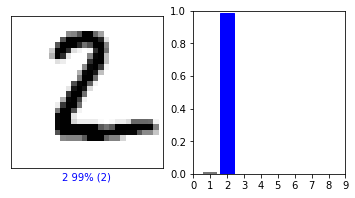

In [12]:
i = 1
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)
print("Предсказание для test_images[1]")
plt.show()

Рис. 5. Предсказание для `test_images[1]`

Посмотрим ещё на несколько изображений с их прогнозами. Цвет верных предсказаний – синий, а неверных – красный. Число – это процент уверенности для предсказанной метки. Стоит отметить, что модель может ошибаться, даже если она очень уверена.

Предсказание для test_images[0] – test_images[14]


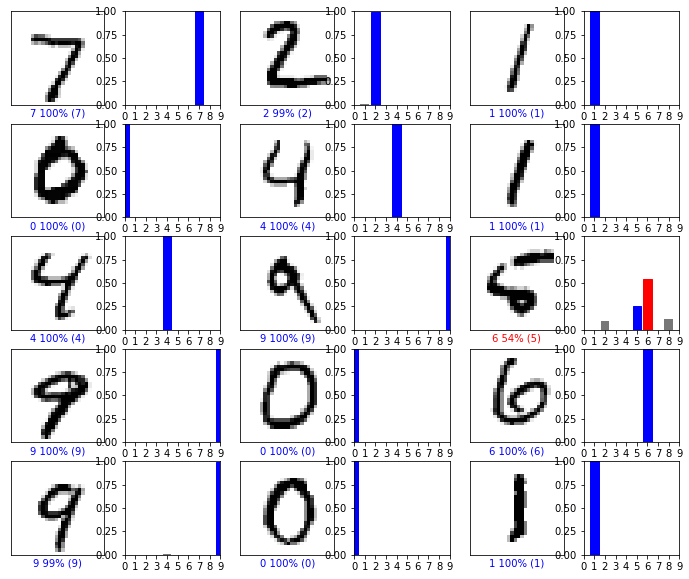

In [13]:
# Отображаем первые X тестовых изображений, их предсказанную и настоящую метки.
# Корректные предсказания окрашиваем в синий цвет, ошибочные в красный.
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions, test_labels)
print("Предсказание для test_images[0] – test_images[14]")
plt.show()

Рис. 6. Предсказание для `test_images[0]` – `test_images[14]`

Теперь напишем обработчик для собственной картинки рукописной цифры. Входящая картинка может быть любого размера, главное, чтобы она была двухцветной (черно-белая, желательно с минимальной градацией серого (иначе нейронная сеть может не распознать цифру, поскольку её обучение проводилось исключительно на бело-черных картинках)). Желательно, чтобы картинка была в формате «`png`»[2], т.к. далее будет рассмотрено как создать свою собственную картинку для классификации при помощи фоторедактора `gimp`.

[2] <span>&#9757;&#128578;</span> `Image.open()` кроме `png` поддерживает множество форматов. Так же был протестирован `jpg`. Стоит отметить, что уровень сжатия сильно влияет на шум в картинке и она может перестать распознаваться (актуально для обоих форматов).

Необходимо наличие тестового файла «`image.png`», который будет открыт и подан в нейросетевую модель для предсказания класса. В нашем случае в данном файле изображена цифра 5.

In [14]:
import os
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter

def imageprepare(path):
    """Эта функция открывает чернобелую картинку, масштабирует её до 28*28 (по большей стороне,
    если картинка не квадратная), нормализует пиксели от 0-255 к 0-1, и возвращает картинку как
    двумерный list с размером 28*28 (и значениями от 0 до 1)

    :param path: путь к картинке
    :return: картинка как двумерный list[28][28] (и значениями от 0 до 1)
    """
    im = Image.open(path).convert("L")  # "L" - один цветовой канал, т.к. оттенки серого
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new("L", (28, 28), (255))  # создает белый холст 28x28

    if width > height:  # проверяем какой размер больше
        # Если ширина больше высоты, то Width становится 28 пикселей, а высоту нормализуем.
        nheight = int(
            round((28.0 / width * height), 0)
        )  # изменить размер высоты в соответствии с соотношением ширины (пропорцией)
        if nheight == 0:  # редкий случай, но высота должна быть минимум 1 пиксель
            nheight = 1
            # изменить размер и резкость
        img = im.resize((28, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))  # вычислить положение по горизонтали
        newImage.paste(
            img, (0, wtop)
        )  # вставить изображение с измененным размером на белый холст
    else:
        # все тоже самое, но если высота больше, то обрезка по ней произойдет
        nwidth = int(round((28.0 / height * width), 0))
        if nwidth == 0:  # rare case but minimum is 1 pixel
            nwidth = 1
        img = im.resize((nwidth, 28), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))
        newImage.paste(img, (wleft, 0))

    file_name = os.path.basename(path)
    new_file_name=os.path.splitext(file_name)[:-1][0] + "_cropped"+ os.path.splitext(file_name)[-1]
    print("Обрезанная картинка сохранена в файл:", new_file_name)
    # сохранить отмасшабированную и обрезанную картинку в файл
    newImage.save(new_file_name)

    tv = list(
        newImage.getdata()
    )  # получить значения пикселей 0-255, только 1 канал цвета

    # нормализовать пиксели до 0 и 1. 0 — чисто белый, 1 — чисто черный.
    tva = [(255 - x) * 1.0 / 255.0 for x in tv]

    # Теперь мы преобразуем массив 1d размером 784 в массив 2d размером 24x24, чтобы мы могли его визуализировать.
    newArr = [[0 for d in range(28)] for y in range(28)]  # создаем пустой список 28*28
    k = 0
    for i in range(28):
        for j in range(28):
            newArr[i][j] = tva[k]
            k = k + 1
    return newArr

img = imageprepare("./image.png")  # file path here
print("Ширина", len(img), "Высота", len(img[0]))
# print(img) #выведет изображение в текстовом формате

Обрезанная картинка сохранена в файл: image_cropped.png
Ширина 28 Высота 28


Представленный выше код откроет картинку `image.png`, отмасштабирует её к формату 28*28 пикселей и запишет в переменную `img` как список значений от 0 до 1 (в качестве значения цвета пикселя). Размер списка тоже 28*28. На картинке ниже (Рис. 7) показано как будет преобразована не квадратная картинка, линиями отмечено, что картинка, была отмасштабирована по высоте с сохранением пропорцией, а по ширине она была уменьшена на тот же коэффициент масштаба, что и по высоте, а далее просто отцентрирована на холсте шириной 28 пикселей.

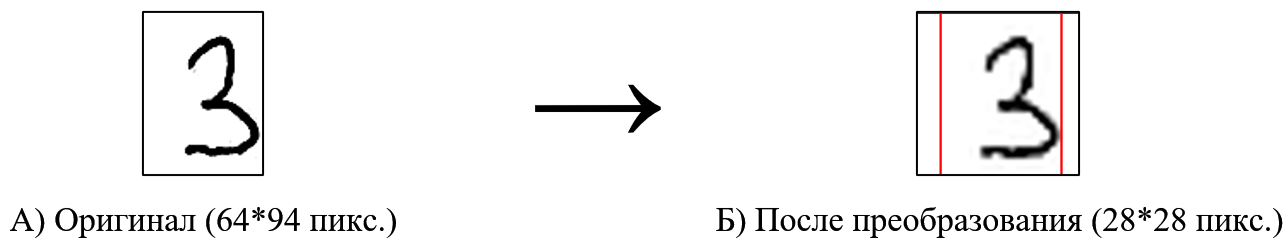

Рис. 7. Преобразование картинки

Преобразованный вариант сохраняется с тем же именем и расширением, но в имя дописывается «`_cropped`». Например, из «`image.png`» получается «`image_cropped.png`». Обратим внимание, что в картинке `image.png` изображена цифра 5, а преобразование цифры 3 на Рис. 7 приведено просто как пример. Про цифру 3 – будет рассмотрено позже.

Модели `tf.keras` оптимизированы для предсказаний по пакетам данных (на англ. пакет – `batch`), т.е. получения предсказаний для множества сетов входных данных сразу. Таким образом, даже если нужно отклассифицировать всего 1 картинку, то все равно необходимо добавить ее в список:

In [15]:
# Добавляем изображение в пакет данных, состоящий только из одного элемента.
img = np.expand_dims(img, 0)

Предскажем для изображения вероятности принадлежности к каждому из 10 классов цифр. Метод `model.predict()` возвращает нам список списков – по одному для каждой картинки в пакете данных. В данном случае в пакете данных только одна картина, поэтому на выходе мы получим двухмерный массив, у которого на первом уровне содержится единственный массив из 10 предсказаний:

In [16]:
predictions_single = model.predict(img)  
print(predictions_single)  

[[4.7776221e-06 1.8669087e-04 2.9800256e-05 9.5937969e-03 2.6956573e-06
  9.8426765e-01 3.6391513e-05 3.9847096e-06 1.8818544e-03 3.9923522e-03]]


Таким образом для рукописной цифры, представленной в вашей картинке (`image.png`), нейронная сеть предскажет степень принадлежности от 0 до 1 к классу, к которому принадлежит эта цифра.

Чтобы получить наибольшую вероятность, можно воспользоваться методом `np.argmax()`, который выведет нам индекс наибольшего значения из массива:

In [17]:
print(np.argmax(predictions_single[0]))  

5


Для большей наглядности, выведем график распределения вероятности принадлежности изображения к классам чисел:

Предсказание для картинки image.png


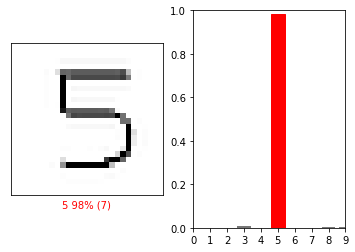

In [18]:
plt.subplot(1, 2, 1) # строка, сколько колонок, индекс колонки в графике
plot_image(0, predictions_single, test_labels, img)
plt.subplot(1, 2, 2) # строка, сколько колонок, индекс колонки в графике
plot_value_array(0, predictions_single, test_labels)
print("Предсказание для картинки image.png")
plt.show()

Рис. 8. Предсказание для `image.png`

Теперь выведем получившуюся модель нейросети:

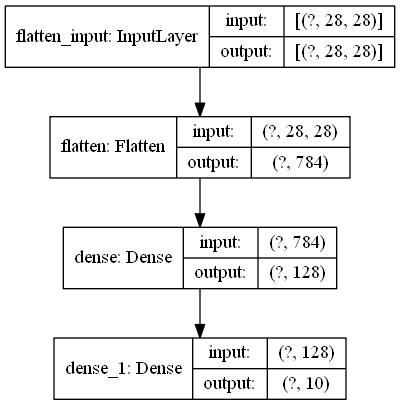

In [19]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

Рис. 9. Модель нейросети для классификации цифр

Модель нейросети для классификации рукописных цифр имеет 128 и 10 основных нейронов на первом и втором слоях соответственно (см. Рис. 9). Эти нейроны и производят распознавание цифр. Нейроны на нулевом слое, помеченном как flatten (с англ. «плоский») – вспомогательные, необходимы для преобразования входного двумерного массива в одномерный и не имеют ни весов, ни смещений для обучения.

Так же мы имеем возможность вывести веса и смещения каждого из слоев. Так как по умолчанию `use_bias=True`[3] (использование нейронов смещения включено), то кроме весов синапсов (связей) нейронов для каждого слоя есть ещё количество смещений, равное количеству выходных синапсов слоя.

[3] <span>&#9757;&#128578;</span> Этот параметр можно было указать для каждого слоя каждом слоя при создании структуры нейросети при помощи кода: `model = keras.Sequential()` (представлен ранее), написав в одном из слоев, например – `keras.layers.Dense(128, activation=“relu”, use_bias=True).` Но по умолчанию – `True`, поэтому и не было указано.

In [20]:
info=[]
for layer_index, layer in enumerate(model.layers):
    info.append(layer.get_weights())  # list of numpy arrays
    if len(info[layer_index])==0:
        print(f"Столько весов/смещений (weights) на {layer_index} слое: {len(info[layer_index])}")
    if len(info[layer_index])==1:
        print(f"Столько весов (weights) для каждого узла (нейрона) на {layer_index} слое: {len(info[layer_index][0])}")
    if len(info[layer_index])==2:
        print(f"Столько весов (weights) для каждого узла (нейрона) на {layer_index} слое: {len(info[layer_index][0])}")
        print(f"Столько смещений (bias) для слоя целиком на {layer_index} слое: {len(info[layer_index][1])}")

layer_number= 2
weight_or_bias=0 #0-веса, 1- смещения
my= info[layer_number][weight_or_bias]
print(f'На последнем слое для каждого из {len(my[0])} нейронов {len(my)} весов:')
print(f'На последнем слое суммарно {len(my)*len(my[0])} весов')

weight_or_bias=1 #0-веса, 1- смещения
my= info[layer_number][weight_or_bias]
print(f'Но при этом на последнем слое всего {len(my)} смещений')
print(f'А "my[0]" - это уже значение первого смещения, т.е. {my[0]}, а не ещё один массив как у весов')

Столько весов/смещений (weights) на 0 слое: 0
Столько весов (weights) для каждого узла (нейрона) на 1 слое: 784
Столько смещений (bias) для слоя целиком на 1 слое: 128
Столько весов (weights) для каждого узла (нейрона) на 2 слое: 128
Столько смещений (bias) для слоя целиком на 2 слое: 10
На последнем слое для каждого из 10 нейронов 128 весов:
На последнем слое суммарно 1280 весов
Но при этом на последнем слое всего 10 смещений
А "my[0]" - это уже значение первого смещения, т.е. -0.12620772421360016, а не ещё один массив как у весов


Конечно, разобраться с весами и смещениями, уже не так просто, как на предыдущем занятии. Так как может показаться, что все они идут вперемешку. Но, если понять представленное ниже, то есть шанс понять вывод из примера выше:

-   каждый нейрон – это узел графа («операция» над несколькими векторами), и каждый нейрон следующего слоя имеет перед собой количество весов, равное количеству нейронов на предыдущем слое, так как сеть в `TensoFlow Keras` всегда полносвязная (и в целом обычно нейронные сети всегда полносвязные – все нейроны связаны между собой);

-   на слое столько смещений, сколько и нейронов на нём, потому что смещение применяется к выходу каждого нейрона (к результату вычисления функции активации);

-   выход каждого нейрона представляет собой математический результат вычисления: сумма входных векторов (значений умноженных на вес), над которой далее вычисляется функция активации, к которой добавляется значение смещения.

Но стоит отметить, что почти всегда нет никакой необходимости углубляться в конкретные значения весов и смещений. Нейронные сети служат в первую очередь как абстракция для решения сложных зависимостей, поэтому прибегать к ручному графовому анализу не имеет никакого смысла. Достаточно создать нейронную сеть, обучить, а далее использовать полученную модель как черный ящик теми же инструментами, что и создавали.

### Подготовка и классификация пользовательской картинки

Теперь попробуем обработать картинку, полученную с камеры. Для этого установите себе на компьютер бесплатный графический редактор `gimp` c открытым исходным кодом (доступен к скачиванию с официального сайта по url: [<u>https://www.gimp.org/downloads/</u>](https://www.gimp.org/downloads/)).

Откроем картинку в `gimp` и откадрируем её, т.е. обрежем так, чтобы не было ничего лишнего (Рис. 10). Рекомендуется после кадрирования получить равное соотношение сторон (т.е. квадрат) – так будет наибольшая точность при распознавании.

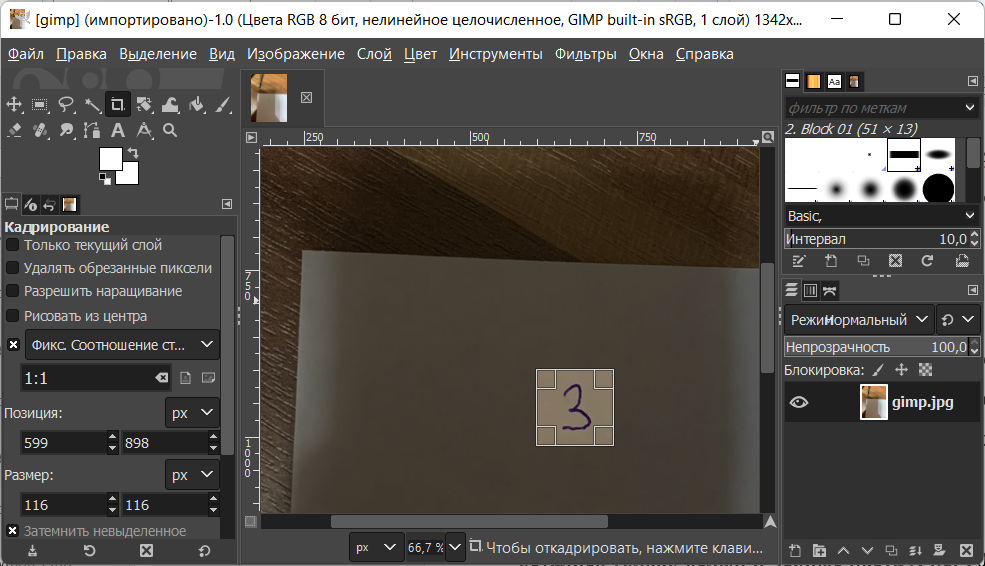

Рис. 10. Кадрирование картинки

Затем обесцветим картинку при помощи верхнего контекстного меню: «Цвет→обесцвечивание→обесцвечивание» (или «Цвет→обесцвечивание», если старая версия `gimp`). Установите среднюю основу оттенков серого как показано на рисунке ниже (Рис. 11).

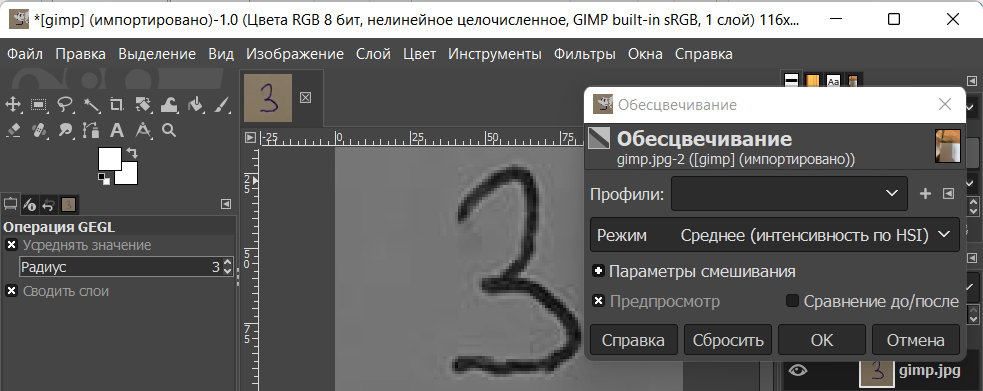

Рис. 11. Обесцвечивание картинки

Настроим яркость/контраст картинки («Цвет→Яркость-контраст»), чтобы остались только белый и черные цвета (Рис. 12).

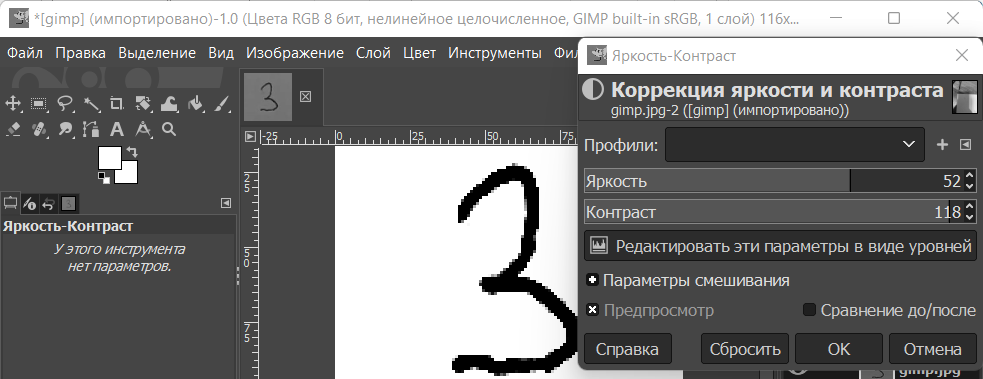

Рис. 12. Изменение яркости/контраста картинки

Теперь экспортируем картинку в формат «`.png`» («Файл→Экспортировать как…»), выбрав степень сжатия, равную нулю (Рис. 13).

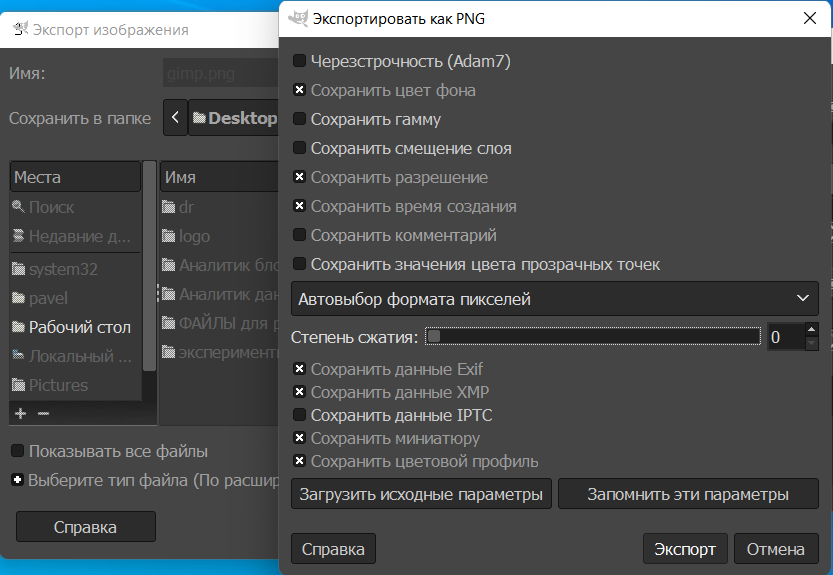

Рис. 13. Экспорт картинки `gimp.png`

Вставим путь к вашей картинке в код ниже. При выполнении данного кода будет осуществлена классификация написанной в изображении цифры:

Обрезанная картинка сохранена в файл: gimp_cropped.png
[[4.1857343e-06 1.1134831e-02 1.8848267e-03 9.7879213e-01 3.7435237e-07
  6.7568087e-04 2.8145823e-07 1.3245094e-05 7.2578760e-03 2.3647505e-04]]
3


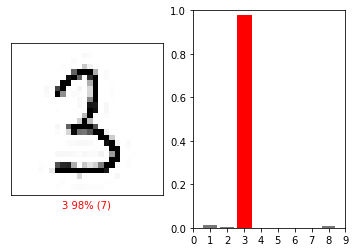

In [21]:
img = imageprepare("./gimp.png")  # file path here
# Добавляем изображение в пакет данных, состоящий только из одного элемента.
img = np.expand_dims(img, 0)
predictions_single = model.predict(img)
print(predictions_single)

print(np.argmax(predictions_single[0]))

plt.subplot(1, 2, 1)
plot_image(0, predictions_single, test_labels, img)
plt.subplot(1, 2, 2)
plot_value_array(0, predictions_single, test_labels)
plt.show()

Рис. 14. Предсказание для картинки `gimp.png`

Представленный выше код такой же, как и рассмотренный ранее в общей части занятия. Он всего лишь продублирован, чтобы вы могли удобно подставить путь к своей картинке и выполнить данный код именно для нее.

### Выводы

На данном занятии была разработана программа для классификации цифр по их изображениям. На основе представленного код, можно создать модель машинного обучения для распознавания любых одиночных объектов на изображениях.

Используя другие датасеты данных, возможно распознавать иные объекты и это даже не потребует правок кода, если формат обучающего датасета аналогичен рассмотренному на занятии. Например, есть в открытом доступе датасеты, представляющие из себя отдельные буквы (датасет `EMNIST`), или рисунки одежды (датасет `Fashion-MNIST`), и формат этих датасетов тоже 28 на 28 пикселей.

Можно получить распознавание многозначных цифр, если доработать код таким образом, чтобы он мог идентифицировать отдельные сегменты изображения с одиночными цифрами. Самый простой способ реализовать это ­– требовать разделения цифр от пользователя, который их пишет. Т.е. требовать писать цифры так, чтобы каждая цифра была на отдельном сегменте изображения – а сделать подобное можно, например, путём разметки листа бумаги квадратными ячейками, как показано на рисунке ниже (Рис. 15).

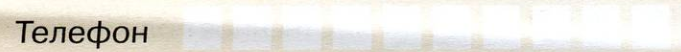

Рис. 15. Сегментированный ввод

Далее код должен обработать каждую такую ячейку, и из отдельных цифр выстроить многозначные цифры.

Для распознавания текста существуют специальные программные средства, называемые утилитами для `OCR` (от англ. Optical Character Recognition – оптическое распознавание символов). Большинство из них построено именно на моделях машинного обучения. Такие программы позволяют распознавать не сегментированные на отдельные символы изображения используя специальные алгоритмы, про которые в данной книге упоминаться не будет.

Стоит отметить, что для `TensoFlow` есть надстройка `TensorFlow Object Detection API`, представляющая собой набор инструментов для создания моделей, которые способны распознавать несколько классов на одном изображении. Это тоже, к сожалению, не будет рассматриваться в данной книге, но главный принцип там заключается в том, что при обучении используются проаннотированные изображения, т.е. изображения, где прямоугольниками выделены разные сегменты, на которых изображены конкретные классы. Например, на рисунке ниже продемонстрировано ручное аннотирование изображений при помощи утилиты `labelImg` (Рис. 16)[4], на основе которого создаются карты меток, используемые при обучении с `Object Detection API.`

[4] <span>&#9757;&#128578;</span> Подробнее представлено в книге – см. источник [21] в списке источников и литературы.

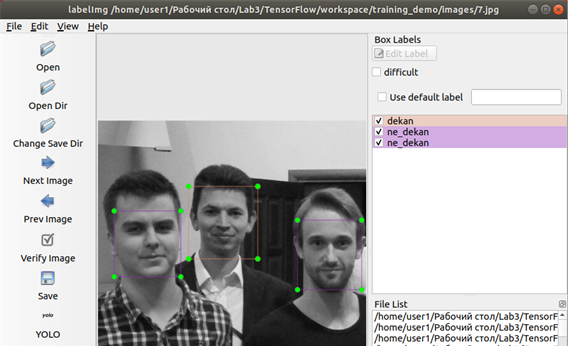

Рис. 16. Ручное аннотирование классов

В завершение занятия удалим все созданные файлы, чтобы не засорять память компьютера:

In [22]:
import os

files = ['gimp_cropped.png', 'image_cropped.png', 'model.png']
for f in files:
    if os.path.isfile(f): # если файл существует
        os.remove(f)

## Контрольные задания и вопросы

1.  Что такое набор данных, или датасет? Для чего может использоваться, как может задаваться (в виде каких типов данных)?

2.  Для чего необходимо разбивать датасет на обучающие выборки и валидирующие (тестировочные)? Что дает тестирование?

3.  Что такое классы объектов? Зачем им нужны имена? Влияет ли имя класса на обучение, или это дополнительное «удобство» при использовании обученной нейросети?

4.  Опишите назначения всех узлов элементов нейросети: входы, синапсы, нейроны, аксоны. Каким узлам соответствуют данные понятия: веса, функции активации?

5.  Каким набором вызова функций библиотеки `Keras` можно определять слои и их параметры (функции активации нейронов на слоях, количество нейронов, тип слоя и прочие параметры)?

6.  Подготовьте собственную картинку цифры, используя один из 40 представленных ниже вариантов (Рис. 17, или на основе своей собственной фотографии). Протестируйте на ней классификацию при помощи нейросети.

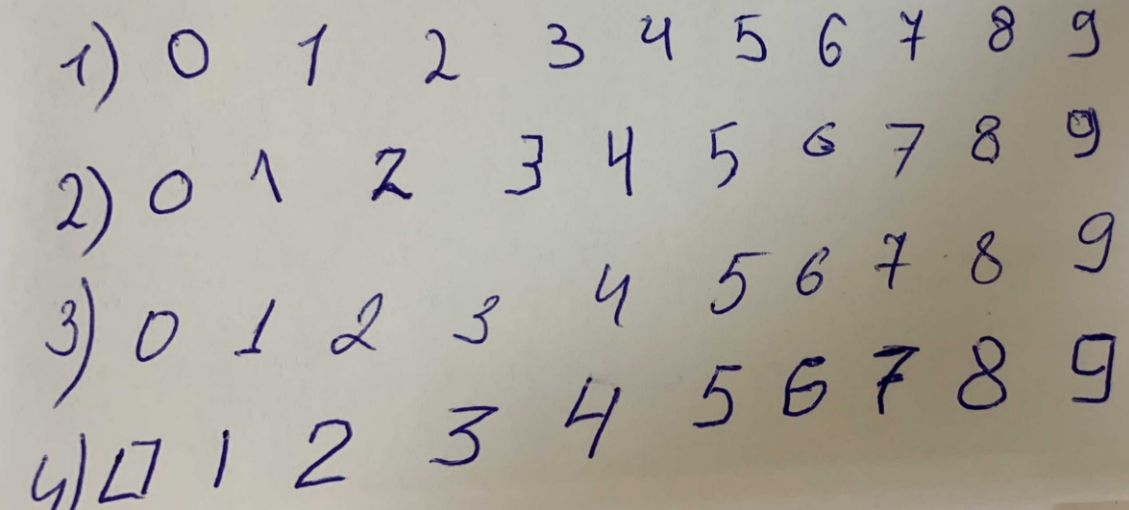

Рис. 17. Варианты индивидуальных заданий